In [474]:
import torch
import numpy as np
from invoke import run
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import itertools
import re
import pandas as pd
import matplotlib.pyplot as mp
from farasa.stemmer import FarasaStemmer
#nltk.download('wordnet')

# Prepare Data

In [592]:
def preprocess_dic(input_dic):
    input_dic = open(input_dic)
    input_dic = [x.split(' ')[0] for x in input_dic]
    #input_dic.insert(0,'<S>')
    #input_dic.insert(1,'<pad>')
    #input_dic.insert(2,'</S>')
    #input_dic.insert(3,'<unk>')
    return input_dic

def normalize(token_index, fname):
    '''make token varations in RoBERTa's dict into the same token '''
    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return ''
        
    if 'roberta' in fname:
        token = roberta_dict[token_index]
        token = token.replace('Ġ', '').lower()
    if 'gpt2' in fname:
        token = gpt2_dict[token_index]
        token = token.replace('Ġ', '').lower()
    if 'AraBERT' in fname:
        token = AraBERT_dict[token_index]
        token = token.replace('##', '').lower()
        return stemmer.stem(token)
        
    if len(token) == 0:
        return token
    token_pos = nltk.pos_tag([token])[0][1]
    token_pos = get_wordnet_pos(token_pos)
    if token_pos is '':
        return lemmatizer.lemmatize(token)
    else:
        return lemmatizer.lemmatize(token, pos=token_pos)

#     if token.endswith('ing'):
#         token.replace('ing', '')
#     if token.endswith('tion'):
#         token.replace('tion', '')
#     if token.endswith('s'):
#         token = token[:-1]
#     if token.endswith('er'):
#         token = token[:-2]
    
    return token

def get_emb_matrix(fname):
    ''' Load the model embeddings matrix and return it'''
    if 'roberta' in fname:
        roberta = torch.load('/home/olab/itayitzhak/bpeplus/roberta.base/model.pt')
        loaded_emb_matrix = roberta['model']['decoder.sentence_encoder.embed_tokens.weight'][4:-4, :]
    if 'gpt2' in fname:
        loaded_emb_matrix = torch.load('/home/olab/itayitzhak/bpeplus/gpt2/gpt2-medium-emb.pt')
    if 'AraBERT' in fname:
        loaded_emb_matrix = torch.load('/home/olab/itayitzhak/bpeplus/AraBERT/bert-large-arabertv02_emb.pt')
        loaded_emb_matrix = loaded_emb_matrix[5:60001, :] # token2char file does not contain speical tokens
    return loaded_emb_matrix

def get_cosine_sim(emb_for_cosine):
    emb_nor = torch.linalg.norm(emb_for_cosine, ord=2, dim=-1)
    emb_nor = emb_nor.unsqueeze(1).expand(emb_for_cosine.size())
    sims = emb_for_cosine/emb_nor
    sims = sims @ sims.T
    return sims

def get_top_k_similar(emb, test_set, k):
    sims = get_cosine_sim(emb)
    top_k = torch.topk(sims, k=k, dim=-1)[1]
    
    return top_k[test_set,:]
   
        
def show_heat_map(emb):
    ax = sns.heatmap(get_cosine_sim(emb).numpy())
    
def get_similarity_split(fname, file_len, k, test_indices, with_lemma=True):
    ''' Returns a data split of random words in tests, and words that are not similar in train'''
    emb_matrix = get_emb_matrix(fname)
    
    test_normalzied_tokens = set()
    if with_lemma:
        for token_index in test_indices:
            test_normalzied_tokens.add(normalize(token_index, fname))
        
    most_similar_words_to_test_set = get_top_k_similar(emb_matrix, test_indices, k)
    
#     print("test_normalzied_tokens", test_normalzied_tokens)
#     print("most_similar_words_to_test_set", most_similar_words_to_test_set)
    count_normal_in_test = 0
    count_normal_in_test_and_not_similar = 0
    
    train_indices = []
    for i in range(file_len):
        if i not in most_similar_words_to_test_set and normalize(i, fname) not in test_normalzied_tokens:
            train_indices.append(i)
#         if normalize(i, fname) in test_normalzied_tokens:
# #             print("This word normalized version is in test:", end=' ')
# #             print(AraBERT_dict[i])
# #             print(normalize(i, fname))
#             count_normal_in_test += 1
#         if i not in most_similar_words_to_test_set and normalize(i, fname) in test_normalzied_tokens:
#             print("Not 20 closest, but it's normalized version is in test:", end=' |')
#             print(i, end=' |')
#             print(AraBERT_dict[i], end=' |')
#             print(normalize(i, fname))
#             count_normal_in_test_and_not_similar += 1
#     print("count_normal_in_test:", count_normal_in_test)
#     print("count_normal_in_test_and_not_similar:", count_normal_in_test_and_not_similar)

    return np.random.permutation(train_indices)#, np.random.permutation(test_indices)

### Viewing similar words in RoBERTa

In [581]:
# model_to_view = 'AraBERT'
# dict_to_use = AraBERT_dict # defined later in the notebook

# emb = get_emb_matrix(folder + 'tokens2char.' + model_to_view +'.txt')
# sims = get_cosine_sim(emb)
# #file_len = get_file_len(folder + 'tokens2char.' + model_to_view +'.txt')
# test_indices = np.random.choice(file_len, 10)

# most_similar_words_to_test_set = get_top_k_similar(emb, test_indices, 30)
# print(most_similar_words_to_test_set)
# #train_indices = [i for i in range(file_len) if i not in most_similar_words_to_test_set]

# #top_k = torch.topk(sims, k=k, dim=-1)[1]

# for i in range(len(test_indices)):
#     print("")
#     print('\033[1m' + dict_to_use[test_indices[i]], end = " - ")
#     for j in range(k):
#         print('\033[0m ('+dict_to_use[most_similar_words_to_test_set[i][j]], end = ",")
#         #print('i:%d, j:%d'%(begin_index+i,top_k[i][j]) , end = ",")
#         #print("%.2f" % cos_sim(emb[begin_index+i],emb[top_k[i][j]]).item(), end =") ")
#         print("%.2f" % sims[test_indices[i],most_similar_words_to_test_set[i][j]].item(), end =") ")
#     #print("="*180)
#     print("")

In [582]:
def get_file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

def get_short_tokens_indicies(fname):
    indices = []
    i = 0
    with open(fname, 'r') as f:
        for line in f.readlines():
            line = line.split(' ')
            token = line[0]
            if 2 < len(token) and len(token) < 5:
                indices.append(i)
            i += 1
    return np.random.permutation(indices)

def get_smart_split(fname, ing_split=False):
    def smart_split_normalize(token):
        '''make token varations in RoBERTa's dict into the same token '''
        return token.replace('Ġ', '').lower()
        
    train_indices = []
    test_indices = []
    train_bucket = set()
    test_bucket = set()
    i = 0
    
    with open(fname, 'r') as f:
        for line in f.readlines():
            line = line.split(' ')
            token = line[0]
            if ing_split and not token.endswith('ing'):
                i += 1
                continue
            # print(f"token: {token}")
            if smart_split_normalize(token) in train_bucket: # token varation already in train
                train_indices.append(i)
            elif smart_split_normalize(token) in test_bucket: # token varation already in test
                test_indices.append(i)
            # token varations has not been seen, add according to split_ratio between train and test
            elif len(train_bucket) / (len(train_bucket) + len(test_bucket) + 1) > split_ratio: # +1 for first token
                test_bucket.add(smart_split_normalize(token))
                test_indices.append(i)
            else:
                train_bucket.add(smart_split_normalize(token))
                train_indices.append(i)
            i += 1
    return np.random.permutation(train_indices), np.random.permutation(test_indices)

def get_random_split(file_len, test_indices):
    train_indices = []
    for i in range(file_len):
        if i not in test_indices:
            train_indices.append(i)
    return np.random.permutation(train_indices)

def get_split_indicies(fname, file_len, split_state, train_size, test_indices=None):
    if split_state == 'random_split':
        return get_random_split(file_len, test_indices)[:train_size], None
    if split_state == 'similarity_split':
        return get_similarity_split(fname, file_len, k, test_indices, with_lemma=False)[:train_size], None
    if split_state == 'lemma_similarity_split':
        return get_similarity_split(fname, file_len, k, test_indices, with_lemma=True)[:train_size], None
    
    if split_state == 'random':
        indicies = np.random.permutation(file_len)
    if split_state == 'only_short_tokens':
        indicies = get_short_tokens_indicies(fname)
    if split_state == 'smart_split':
        return get_smart_split(fname)
    if split_state == 'ing_split':
        return get_smart_split(fname, ing_split=True)
    
    if '2k_split' in split_state:
        train_indices, test_indices = get_smart_split(fname)
        return train_indices[:1080], test_indices[:1080]
    if 'smart_similarity' in split_state:
#         train_indices, test_indices = get_similarity_split(fname, file_len, k, test_size)
#         return smart_filter_train(train_indices, test_indices)
        return get_similarity_split(fname, file_len, k, test_size)
    
    if 'control_similarity' in split_state:
        train_indices, test_indices = get_smart_split(fname)
        return train_indices[:33000], test_indices[:2000]
    if 'similarity_split' in split_state:
        return get_similarity_split(fname, file_len, k, test_size)
    
    train_amount = int(split_ratio*len(indicies))
    return indicies[:train_amount], indicies[train_amount:]

In [593]:
def create_train_val_test_files(input_fname, file_len, split_state, train_size, output_prefix, test_indices):
    train_file = open(output_prefix  + '.train', "w", encoding='utf8')
    valid_file = open(output_prefix + '.valid', "w", encoding='utf8')
    test_file = open(output_prefix + '.test', "w", encoding='utf8')
    
    train_indices, _ = get_split_indicies(input_fname, file_len, split_state, train_size, test_indices)
    
    with open(input_fname, 'r', encoding='utf8') as input_f:
        for i, line in enumerate(input_f.readlines()):
            if i in train_indices:
                train_file.write(line)
            elif i in test_indices:
                valid_file.write(line)
                test_file.write(line)
    
    train_file.close()
    valid_file.close()
    test_file.close()
    

In [594]:
def create_data_and_preprocess(lang, dict_path=None, with_shtrudel=""):
    input_fname = folder + 'tokens2char.' + lang + with_shtrudel +'.txt'
    
    file_len = get_file_len(input_fname)
    test_indices = np.random.choice(file_len, test_size) # last tokens appeared very few times, choose 50,000 for RoBERTA

    for split_state, train_size in list(itertools.product(splits,train_sizes)):
        output_prefix = input_fname + '.' + f'{seed}_{split_state}_train_size_{train_size}'
        create_train_val_test_files(input_fname, file_len, split_state, train_size, output_prefix, test_indices)
        
        if lang == 'roberta.base' or 'gpt2' in lang or 'AraBERT' in lang:
            run("fairseq-preprocess" + "" + \
                "  --only-source " + "" + \
                "  --trainpref " + output_prefix +".train" + "" + \
                "  --validpref " + output_prefix +".valid" + "" + \
                "  --testpref " + output_prefix +".test" + "" + \
                "  --destdir " + output_prefix + "" + \
                "  --workers 20 " + "" + \
                f"  --tokenizer space --srcdict {dict_path}"
               )
        else:
            data_name = fname + '.' + split_state + f'_{split_ratio}'
            run("fairseq-preprocess" + "" + \
                "  --only-source " + "" + \
                "  --trainpref " + data_name +".train" + "" + \
                "  --validpref " + data_name +".valid" + "" + \
                "  --testpref " + data_name +".test" + "" + \
                "  --destdir " + data_name + "" + \
                "  --workers 20 " + "" + \
                "  --tokenizer space --srcdict /home/olab/itayitzhak/bpeplus/fairseq/data-bin/iwslt14.tokenized." + lang + "-en/dict.en.txt"
               )


In [595]:
folder = '/home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/'
checkpoints_folder = '/home/olab/itayitzhak/bpeplus/fairseq/checkpoints/'

roberta_dict_path = '/home/olab/itayitzhak/bpeplus/roberta.base/real_dict.txt'
roberta_dict = preprocess_dic(roberta_dict_path)
gpt2_dict_path = '/home/olab/itayitzhak/bpeplus/gpt2/dict.txt'
gpt2_dict = preprocess_dic(gpt2_dict_path)
AraBERT_dict_path = '/home/olab/itayitzhak/bpeplus/AraBERT/dict.txt'
AraBERT_dict = preprocess_dic(AraBERT_dict_path)

#lemmatizer = WordNetLemmatizer()
#stemmer = FarasaStemmer(interactive=True)

In [ ]:
split_ratio = 0.5
k = 20
test_size = 1000
#seed = 0
#split_state = 'random'
#split_state = 'only_short_tokens'
#split_state = 'smart_split'
#split_state = 'ing_split'
#split_state = f'2k_split_seed_{seed}'
#split_state = f'control_similarity_split_seed_{seed}'
#split_state = f'similarity_split_seed_{seed}'
#split_state = f'lemma_similarity_split_seed_{seed}'

seeds = [1,2,3,4,5,6,7,8,9]
splits = ['random_split','similarity_split', 'lemma_similarity_split']
train_sizes = [1000,2000,4000,8000,16000,32000]

for seed in seeds:
    np.random.seed(seed)
    #create_data_and_preprocess('roberta.base')
    create_data_and_preprocess('AraBERT',dict_path=gpt2_dict_path)

2021-07-28 12:46:37 | INFO | fairseq_cli.preprocess | Namespace(add_token_unicode_characters_embeddings=False, align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='/home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.1_random_split_train_size_1000', dont_send_comet_ml=False, empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=True, optimizer=None, padding_factor=8, path_to_load_embeddings=None, profile=False, quantization_config_path=None, reset_chars_emb=False, reset_logging=False, scoring='ble

2021-07-28 12:47:55 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.1_random_split_train_size_4000.valid: 984 sents, 7343 tokens, 83.4% replaced by <unk>
2021-07-28 12:47:55 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 12:47:58 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.1_random_split_train_size_4000.test: 984 sents, 7343 tokens, 83.4% replaced by <unk>
2021-07-28 12:47:58 | INFO | fairseq_cli.preprocess | Wrote preprocessed data to /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.1_random_split_train_size_4000
2021-07-28 12:48:22 | INFO | fairseq_cli.preprocess | Namespace(add_token_unicode_characters_embeddings=False, align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False, bf16=False

2021-07-28 12:49:39 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 12:49:45 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.1_random_split_train_size_32000.train: 32000 sents, 236847 tokens, 83.6% replaced by <unk>
2021-07-28 12:49:45 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 12:49:49 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.1_random_split_train_size_32000.valid: 984 sents, 7343 tokens, 83.4% replaced by <unk>
2021-07-28 12:49:49 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 12:49:53 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.1_random_split_train_size_32000.test: 984 sents, 7343 tokens, 83.4% replaced by <

[2021-07-28 12:51:50,476 - farasapy_logger - ERROR]: pipe broke! error code and message: [[Errno 32] Broken pipe]. reinitailize the process.., This may take sometime depending on the running task


2021-07-28 12:53:27 | INFO | fairseq_cli.preprocess | Namespace(add_token_unicode_characters_embeddings=False, align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='/home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.1_similarity_split_train_size_1000', dont_send_comet_ml=False, empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=True, optimizer=None, padding_factor=8, path_to_load_embeddings=None, profile=False, quantization_config_path=None, reset_chars_emb=False, reset_logging=False, scoring=

2021-07-28 13:00:22 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.1_similarity_split_train_size_4000.valid: 984 sents, 7343 tokens, 83.4% replaced by <unk>
2021-07-28 13:00:22 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 13:00:25 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.1_similarity_split_train_size_4000.test: 984 sents, 7343 tokens, 83.4% replaced by <unk>
2021-07-28 13:00:25 | INFO | fairseq_cli.preprocess | Wrote preprocessed data to /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.1_similarity_split_train_size_4000
2021-07-28 13:03:16 | INFO | fairseq_cli.preprocess | Namespace(add_token_unicode_characters_embeddings=False, align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False

2021-07-28 13:09:12 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 13:09:18 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.1_similarity_split_train_size_32000.train: 32000 sents, 235169 tokens, 83.6% replaced by <unk>
2021-07-28 13:09:18 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 13:09:22 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.1_similarity_split_train_size_32000.valid: 984 sents, 7343 tokens, 83.4% replaced by <unk>
2021-07-28 13:09:22 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 13:09:26 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.1_similarity_split_train_size_32000.test: 984 sents, 7343 tokens, 83.4% r

2021-07-28 13:24:07 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 13:24:13 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.1_lemma_similarity_split_train_size_16000.valid: 984 sents, 7343 tokens, 83.4% replaced by <unk>
2021-07-28 13:24:13 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 13:24:17 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.1_lemma_similarity_split_train_size_16000.test: 984 sents, 7343 tokens, 83.4% replaced by <unk>
2021-07-28 13:24:17 | INFO | fairseq_cli.preprocess | Wrote preprocessed data to /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.1_lemma_similarity_split_train_size_16000
2021-07-28 13:27:06 | INFO | fairseq_cli.preprocess | Namespace(add_token_unicode_charact

2021-07-28 13:28:19 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 13:28:23 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.2_random_split_train_size_2000.train: 2000 sents, 14908 tokens, 84.0% replaced by <unk>
2021-07-28 13:28:23 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 13:28:26 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.2_random_split_train_size_2000.valid: 990 sents, 7416 tokens, 84.2% replaced by <unk>
2021-07-28 13:28:26 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 13:28:29 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.2_random_split_train_size_2000.test: 990 sents, 7416 tokens, 84.2% replaced by <unk>


2021-07-28 13:34:30 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.2_similarity_split_train_size_1000.valid: 990 sents, 7416 tokens, 84.2% replaced by <unk>
2021-07-28 13:34:30 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 13:34:33 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.2_similarity_split_train_size_1000.test: 990 sents, 7416 tokens, 84.2% replaced by <unk>
2021-07-28 13:34:33 | INFO | fairseq_cli.preprocess | Wrote preprocessed data to /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.2_similarity_split_train_size_1000
2021-07-28 13:37:16 | INFO | fairseq_cli.preprocess | Namespace(add_token_unicode_characters_embeddings=False, align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False

2021-07-28 13:43:21 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 13:43:27 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.2_similarity_split_train_size_8000.train: 8000 sents, 58794 tokens, 83.5% replaced by <unk>
2021-07-28 13:43:27 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 13:43:31 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.2_similarity_split_train_size_8000.valid: 990 sents, 7416 tokens, 84.2% replaced by <unk>
2021-07-28 13:43:31 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 13:43:34 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.2_similarity_split_train_size_8000.test: 990 sents, 7416 tokens, 84.2% replac

2021-07-28 13:58:14 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 13:58:17 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.2_lemma_similarity_split_train_size_4000.valid: 990 sents, 7416 tokens, 84.2% replaced by <unk>
2021-07-28 13:58:17 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 13:58:21 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.2_lemma_similarity_split_train_size_4000.test: 990 sents, 7416 tokens, 84.2% replaced by <unk>
2021-07-28 13:58:21 | INFO | fairseq_cli.preprocess | Wrote preprocessed data to /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.2_lemma_similarity_split_train_size_4000
2021-07-28 14:01:05 | INFO | fairseq_cli.preprocess | Namespace(add_token_unicode_characters

2021-07-28 14:07:07 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 14:07:13 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.2_lemma_similarity_split_train_size_32000.train: 32000 sents, 235510 tokens, 83.4% replaced by <unk>
2021-07-28 14:07:13 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 14:07:16 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.2_lemma_similarity_split_train_size_32000.valid: 990 sents, 7416 tokens, 84.2% replaced by <unk>
2021-07-28 14:07:16 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 14:07:19 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.2_lemma_similarity_split_train_size_32000.test: 990 sents, 74

2021-07-28 14:10:22 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.3_random_split_train_size_16000.valid: 986 sents, 7221 tokens, 83.2% replaced by <unk>
2021-07-28 14:10:22 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 14:10:25 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.3_random_split_train_size_16000.test: 986 sents, 7221 tokens, 83.2% replaced by <unk>
2021-07-28 14:10:25 | INFO | fairseq_cli.preprocess | Wrote preprocessed data to /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.3_random_split_train_size_16000
2021-07-28 14:10:53 | INFO | fairseq_cli.preprocess | Namespace(add_token_unicode_characters_embeddings=False, align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False, bf16=Fa

2021-07-28 14:16:43 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 14:16:47 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.3_similarity_split_train_size_2000.train: 2000 sents, 14680 tokens, 83.7% replaced by <unk>
2021-07-28 14:16:47 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 14:16:51 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.3_similarity_split_train_size_2000.valid: 986 sents, 7221 tokens, 83.2% replaced by <unk>
2021-07-28 14:16:51 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 14:16:54 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.3_similarity_split_train_size_2000.test: 986 sents, 7221 tokens, 83.2% replac

2021-07-28 14:32:02 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 14:32:06 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.3_lemma_similarity_split_train_size_1000.valid: 986 sents, 7221 tokens, 83.2% replaced by <unk>
2021-07-28 14:32:06 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 14:32:10 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.3_lemma_similarity_split_train_size_1000.test: 986 sents, 7221 tokens, 83.2% replaced by <unk>
2021-07-28 14:32:10 | INFO | fairseq_cli.preprocess | Wrote preprocessed data to /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.3_lemma_similarity_split_train_size_1000
2021-07-28 14:34:55 | INFO | fairseq_cli.preprocess | Namespace(add_token_unicode_characters

2021-07-28 14:40:46 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 14:40:50 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.3_lemma_similarity_split_train_size_8000.train: 8000 sents, 59144 tokens, 83.7% replaced by <unk>
2021-07-28 14:40:50 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 14:40:53 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.3_lemma_similarity_split_train_size_8000.valid: 986 sents, 7221 tokens, 83.2% replaced by <unk>
2021-07-28 14:40:53 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 14:40:56 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.3_lemma_similarity_split_train_size_8000.test: 986 sents, 7221 to

2021-07-28 14:48:54 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.4_random_split_train_size_4000.valid: 991 sents, 7276 tokens, 83.1% replaced by <unk>
2021-07-28 14:48:54 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 14:48:57 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.4_random_split_train_size_4000.test: 991 sents, 7276 tokens, 83.1% replaced by <unk>
2021-07-28 14:48:57 | INFO | fairseq_cli.preprocess | Wrote preprocessed data to /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.4_random_split_train_size_4000
2021-07-28 14:49:27 | INFO | fairseq_cli.preprocess | Namespace(add_token_unicode_characters_embeddings=False, align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False, bf16=False

2021-07-28 14:50:53 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 14:50:59 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.4_random_split_train_size_32000.train: 32000 sents, 236980 tokens, 83.7% replaced by <unk>
2021-07-28 14:50:59 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 14:51:02 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.4_random_split_train_size_32000.valid: 991 sents, 7276 tokens, 83.1% replaced by <unk>
2021-07-28 14:51:02 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 14:51:05 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.4_random_split_train_size_32000.test: 991 sents, 7276 tokens, 83.1% replaced by <

2021-07-28 15:06:06 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.4_similarity_split_train_size_16000.valid: 991 sents, 7276 tokens, 83.1% replaced by <unk>
2021-07-28 15:06:06 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 15:06:10 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.4_similarity_split_train_size_16000.test: 991 sents, 7276 tokens, 83.1% replaced by <unk>
2021-07-28 15:06:10 | INFO | fairseq_cli.preprocess | Wrote preprocessed data to /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.4_similarity_split_train_size_16000
2021-07-28 15:09:02 | INFO | fairseq_cli.preprocess | Namespace(add_token_unicode_characters_embeddings=False, align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=Fa

2021-07-28 15:15:12 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 15:15:15 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.4_lemma_similarity_split_train_size_2000.train: 2000 sents, 14735 tokens, 83.6% replaced by <unk>
2021-07-28 15:15:16 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 15:15:20 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.4_lemma_similarity_split_train_size_2000.valid: 991 sents, 7276 tokens, 83.1% replaced by <unk>
2021-07-28 15:15:20 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 15:15:24 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.4_lemma_similarity_split_train_size_2000.test: 991 sents, 7276 to

2021-07-28 15:27:51 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.5_random_split_train_size_1000.valid: 989 sents, 7349 tokens, 83.8% replaced by <unk>
2021-07-28 15:27:51 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 15:27:54 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.5_random_split_train_size_1000.test: 989 sents, 7349 tokens, 83.8% replaced by <unk>
2021-07-28 15:27:54 | INFO | fairseq_cli.preprocess | Wrote preprocessed data to /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.5_random_split_train_size_1000
2021-07-28 15:28:17 | INFO | fairseq_cli.preprocess | Namespace(add_token_unicode_characters_embeddings=False, align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False, bf16=False

2021-07-28 15:29:36 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 15:29:40 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.5_random_split_train_size_8000.train: 8000 sents, 58909 tokens, 83.7% replaced by <unk>
2021-07-28 15:29:40 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 15:29:44 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.5_random_split_train_size_8000.valid: 989 sents, 7349 tokens, 83.8% replaced by <unk>
2021-07-28 15:29:44 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 15:29:49 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.5_random_split_train_size_8000.test: 989 sents, 7349 tokens, 83.8% replaced by <unk>


2021-07-28 15:40:07 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.5_similarity_split_train_size_4000.valid: 989 sents, 7349 tokens, 83.8% replaced by <unk>
2021-07-28 15:40:07 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 15:40:10 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.5_similarity_split_train_size_4000.test: 989 sents, 7349 tokens, 83.8% replaced by <unk>
2021-07-28 15:40:10 | INFO | fairseq_cli.preprocess | Wrote preprocessed data to /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.5_similarity_split_train_size_4000
2021-07-28 15:42:52 | INFO | fairseq_cli.preprocess | Namespace(add_token_unicode_characters_embeddings=False, align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False

2021-07-28 15:48:54 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 15:49:03 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.5_similarity_split_train_size_32000.train: 32000 sents, 235128 tokens, 83.5% replaced by <unk>
2021-07-28 15:49:03 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 15:49:06 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.5_similarity_split_train_size_32000.valid: 989 sents, 7349 tokens, 83.8% replaced by <unk>
2021-07-28 15:49:06 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 15:49:09 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.5_similarity_split_train_size_32000.test: 989 sents, 7349 tokens, 83.8% r

2021-07-28 16:03:51 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 16:03:54 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.5_lemma_similarity_split_train_size_16000.valid: 989 sents, 7349 tokens, 83.8% replaced by <unk>
2021-07-28 16:03:54 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 16:03:57 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.5_lemma_similarity_split_train_size_16000.test: 989 sents, 7349 tokens, 83.8% replaced by <unk>
2021-07-28 16:03:57 | INFO | fairseq_cli.preprocess | Wrote preprocessed data to /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.5_lemma_similarity_split_train_size_16000
2021-07-28 16:06:46 | INFO | fairseq_cli.preprocess | Namespace(add_token_unicode_charact

2021-07-28 16:07:59 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 16:08:03 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.6_random_split_train_size_2000.train: 2000 sents, 14885 tokens, 83.9% replaced by <unk>
2021-07-28 16:08:03 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 16:08:06 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.6_random_split_train_size_2000.valid: 989 sents, 7287 tokens, 83.7% replaced by <unk>
2021-07-28 16:08:06 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 16:08:10 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.6_random_split_train_size_2000.test: 989 sents, 7287 tokens, 83.7% replaced by <unk>


2021-07-28 16:13:39 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.6_similarity_split_train_size_1000.valid: 989 sents, 7287 tokens, 83.7% replaced by <unk>
2021-07-28 16:13:39 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 16:13:42 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.6_similarity_split_train_size_1000.test: 989 sents, 7287 tokens, 83.7% replaced by <unk>
2021-07-28 16:13:42 | INFO | fairseq_cli.preprocess | Wrote preprocessed data to /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.6_similarity_split_train_size_1000
2021-07-28 16:16:25 | INFO | fairseq_cli.preprocess | Namespace(add_token_unicode_characters_embeddings=False, align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False

2021-07-28 16:22:19 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 16:22:24 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.6_similarity_split_train_size_8000.train: 8000 sents, 58820 tokens, 83.5% replaced by <unk>
2021-07-28 16:22:24 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 16:22:28 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.6_similarity_split_train_size_8000.valid: 989 sents, 7287 tokens, 83.7% replaced by <unk>
2021-07-28 16:22:28 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 16:22:31 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.6_similarity_split_train_size_8000.test: 989 sents, 7287 tokens, 83.7% replac

2021-07-28 16:37:25 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.6_lemma_similarity_split_train_size_4000.valid: 989 sents, 7287 tokens, 83.7% replaced by <unk>
2021-07-28 16:37:25 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 16:37:28 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.6_lemma_similarity_split_train_size_4000.test: 989 sents, 7287 tokens, 83.7% replaced by <unk>
2021-07-28 16:37:28 | INFO | fairseq_cli.preprocess | Wrote preprocessed data to /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.6_lemma_similarity_split_train_size_4000
2021-07-28 16:40:20 | INFO | fairseq_cli.preprocess | Namespace(add_token_unicode_characters_embeddings=False, align_suffix=None, alignfile=None, all_gather_list_size=16384, azu

2021-07-28 16:46:20 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 16:46:25 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.6_lemma_similarity_split_train_size_32000.train: 32000 sents, 236137 tokens, 83.5% replaced by <unk>
2021-07-28 16:46:25 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 16:46:29 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.6_lemma_similarity_split_train_size_32000.valid: 989 sents, 7287 tokens, 83.7% replaced by <unk>
2021-07-28 16:46:29 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 16:46:32 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.6_lemma_similarity_split_train_size_32000.test: 989 sents, 72

2021-07-28 16:49:29 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.7_random_split_train_size_16000.valid: 995 sents, 7469 tokens, 83.8% replaced by <unk>
2021-07-28 16:49:29 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 16:49:33 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.7_random_split_train_size_16000.test: 995 sents, 7469 tokens, 83.8% replaced by <unk>
2021-07-28 16:49:33 | INFO | fairseq_cli.preprocess | Wrote preprocessed data to /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.7_random_split_train_size_16000
2021-07-28 16:50:00 | INFO | fairseq_cli.preprocess | Namespace(add_token_unicode_characters_embeddings=False, align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False, bf16=Fa

2021-07-28 16:55:51 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 16:55:55 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.7_similarity_split_train_size_2000.train: 2000 sents, 14668 tokens, 83.7% replaced by <unk>
2021-07-28 16:55:55 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 16:55:58 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.7_similarity_split_train_size_2000.valid: 995 sents, 7469 tokens, 83.8% replaced by <unk>
2021-07-28 16:55:58 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 16:56:01 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.7_similarity_split_train_size_2000.test: 995 sents, 7469 tokens, 83.8% replac

2021-07-28 17:10:44 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 17:10:48 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.7_lemma_similarity_split_train_size_1000.valid: 995 sents, 7469 tokens, 83.8% replaced by <unk>
2021-07-28 17:10:48 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 17:10:51 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.7_lemma_similarity_split_train_size_1000.test: 995 sents, 7469 tokens, 83.8% replaced by <unk>
2021-07-28 17:10:51 | INFO | fairseq_cli.preprocess | Wrote preprocessed data to /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.7_lemma_similarity_split_train_size_1000
2021-07-28 17:13:37 | INFO | fairseq_cli.preprocess | Namespace(add_token_unicode_characters

2021-07-28 17:19:38 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 17:19:43 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.7_lemma_similarity_split_train_size_8000.train: 8000 sents, 58707 tokens, 83.5% replaced by <unk>
2021-07-28 17:19:43 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 17:19:46 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.7_lemma_similarity_split_train_size_8000.valid: 995 sents, 7469 tokens, 83.8% replaced by <unk>
2021-07-28 17:19:46 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 17:19:50 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.7_lemma_similarity_split_train_size_8000.test: 995 sents, 7469 to

2021-07-28 17:27:28 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.8_random_split_train_size_4000.valid: 991 sents, 7338 tokens, 83.5% replaced by <unk>
2021-07-28 17:27:28 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 17:27:32 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.8_random_split_train_size_4000.test: 991 sents, 7338 tokens, 83.5% replaced by <unk>
2021-07-28 17:27:32 | INFO | fairseq_cli.preprocess | Wrote preprocessed data to /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.8_random_split_train_size_4000
2021-07-28 17:27:56 | INFO | fairseq_cli.preprocess | Namespace(add_token_unicode_characters_embeddings=False, align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False, bf16=False

2021-07-28 17:29:19 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 17:29:25 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.8_random_split_train_size_32000.train: 32000 sents, 237165 tokens, 83.7% replaced by <unk>
2021-07-28 17:29:25 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 17:29:29 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.8_random_split_train_size_32000.valid: 991 sents, 7338 tokens, 83.5% replaced by <unk>
2021-07-28 17:29:29 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 17:29:32 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.8_random_split_train_size_32000.test: 991 sents, 7338 tokens, 83.5% replaced by <

2021-07-28 17:44:12 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 17:44:15 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.8_similarity_split_train_size_16000.valid: 991 sents, 7338 tokens, 83.5% replaced by <unk>
2021-07-28 17:44:15 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 17:44:19 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.8_similarity_split_train_size_16000.test: 991 sents, 7338 tokens, 83.5% replaced by <unk>
2021-07-28 17:44:19 | INFO | fairseq_cli.preprocess | Wrote preprocessed data to /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.8_similarity_split_train_size_16000
2021-07-28 17:47:08 | INFO | fairseq_cli.preprocess | Namespace(add_token_unicode_characters_embeddings=Fal

2021-07-28 17:53:06 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 17:53:10 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.8_lemma_similarity_split_train_size_2000.train: 2000 sents, 14729 tokens, 83.3% replaced by <unk>
2021-07-28 17:53:10 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 17:53:14 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.8_lemma_similarity_split_train_size_2000.valid: 991 sents, 7338 tokens, 83.5% replaced by <unk>
2021-07-28 17:53:14 | INFO | fairseq_cli.preprocess | [None] Dictionary: 50261 types
2021-07-28 17:53:17 | INFO | fairseq_cli.preprocess | [None] /home/olab/itayitzhak/bpeplus/fairseq/data-bin/spelling_data/organized_tests/tokens2char.AraBERT.txt.8_lemma_similarity_split_train_size_2000.test: 991 sents, 7338 to

In [588]:
# token_index = 6900
# print(roberta_dict[token_index])
# token = roberta_dict[token_index]
# token = token.replace('Ġ', '').lower()
# token_pos = nltk.pos_tag([token])
# print(token_pos)
# print(get_wordnet_pos(token_pos[0][1]))
# lemmatizer.lemmatize(token, pos=get_wordnet_pos(token_pos[0][1]))
print(stemmer.stem("الاعتبار"))
print(stemmer.stem("اعتبارا")) # in test


اعتبار
اعتباري
اعتبار


In [426]:
# create_data_and_preprocess('he')
# create_data_and_preprocess('de')
# create_data_and_preprocess('ar')
# create_data_and_preprocess('roberta.base')

# Evaluation

In [626]:
def get_edit_distance(s1, s2):
    dist = 0
    for i in range(min(len(s1),len(s2))):
        if s1[i] != s2[i]:
            dist += 1
    dist += abs(len(s1)-len(s1))
    
    return dist
                   
def get_char_f1(token_from_chars, token):
    precision = 0
    recall = 0
    
    if len(token_from_chars) == 0:
        return 0
    
    for c in token_from_chars:
        if c in token:
            precision += 1
    for c in token:
        if c in token_from_chars:
            recall += 1
    
    precision /= len(token_from_chars)
    recall /= len(token)
            
    if precision+recall == 0:
        return 0
    else:
        return 2*(precision*recall)/(precision+recall)
            

In [627]:
def get_accuracy(fname, exact_match=True):
    total_num = 0
    num_correct = 0
    num_correct_num_of_chars = 0
    edit_distance = 0
    char_f1 = 0
    
    with open(fname, 'r') as f:
        for line in f.readlines():
            if line[0] == 'H':
                total_num += 1
                line = line.replace('\n','').split('\t')[2].split(' ')
                token = line[0].strip()
                #print(f"total_num:{total_num}; line:{line}")
                token_from_chars = ''.join(line[1:])
                if exact_match and token == token_from_chars and len(token) > 0:
                    #print(f"correct token:", line)
                    num_correct += 1
                if len(token) == len(token_from_chars):
                    num_correct_num_of_chars += 1
                
                edit_distance += get_edit_distance(token_from_chars, token)    
                char_f1 += get_char_f1(token_from_chars, token)
                        
            if 'Generate test with beam=1: BLEU4' in line:
                bleu_idx = re.search('BLEU4', line).span()[1]+3
                try:
                    bleu_score = float((line[bleu_idx:bleu_idx+5]))
                except:
                    bleu_score = float((line[bleu_idx:bleu_idx+4]))
#     print("="*80)
#     print(f"Total lines: {total_num}, num_correct:{num_correct}")
#     print(f"File is {fname}")
    if total_num == 0:
        print(fname.split('/')[7])
    return num_correct/total_num, bleu_score, num_correct_num_of_chars/total_num, edit_distance/total_num, char_f1/total_num

In [620]:
#model_to_eval = 'roberta.base_smart_split_0.5_decoder_embed_dim_512'
#model_to_eval = 'roberta.base_lemma_similarity_split_seed_0_0.5_freeze_emb_decoder_embed_dim_512'
model_to_eval = 'roberta.base_5_lemma_similarity_split_train_size_32000roberta.large_decoder_embed_dim_512'
#model_to_eval = 'roberta.base_2k_split_seed_2_0.5_freeze_emb_decoder_embed_dim_512'
#model_to_eval = 'he_spelling_random_0.5'

#acc = get_accuracy("/home/olab/itayitzhak/bpeplus/fairseq/checkpoints/trained_he_spelling_random_0.5/generate-test.txt")
acc, bleu_score, correct_len, ham, f_1 = get_accuracy(checkpoints_folder+"trained_"+model_to_eval+"/generate-test.txt")

print("Model:", model_to_eval)
print(f"Percentage of tokens with correct number of chars:"+" {:.2%}".format(correct_len))
print("Exact match tokens spelling: {:.2%}".format(acc))
print("Bleu:", bleu_score)

acc, bleu_score, correct_len, ham, f_1 = get_accuracy(checkpoints_folder+"not_trained_"+model_to_eval+"/generate-test.txt")
print("Not Trained:")
print("Exact match tokens spelling: {:.2%}".format(acc))
print("Bleu:", bleu_score)

Model: roberta.base_5_lemma_similarity_split_train_size_32000roberta.large_decoder_embed_dim_512
Percentage of tokens with correct number of chars: 45.64%
Exact match tokens spelling: 16.23%
Bleu: 33.16
Not Trained:
Exact match tokens spelling: 0.00%
Bleu: 2.2


### Create Results Table

In [624]:
model_name = 'AraBERT'

if model_name == 'roberta.base':
    data_name = 'roberta.base'
    model_name_path = ''
if model_name == 'roberta.large':
    data_name = 'roberta.base'
    model_name_path = model_name
if model_name == 'gpt2':
    data_name = 'gpt2.medium'
    model_name_path = model_name
if 'AraBERT' in model_name:
    data_name = model_name
    model_name_path = model_name

load_emb_options = ["trained", "not_trained"]
seeds = [0]#[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
splits = ['random_split', 'similarity_split', 'lemma_similarity_split']
train_sizes = [1000, 2000, 4000, 8000, 16000, 32000]

results_file_path = checkpoints_folder + f"{model_name}_results.csv"
results_file = open(results_file_path, 'w+')
results_file.write("split_state,is_load_emb,train_size,EM_score,Bleu_score,Edit_dist,f_1,correct_length\n")

for is_load_emb, split_state, train_size in list(
        itertools.product(load_emb_options, splits, train_sizes)):
    sum_curr_model_em = 0
    sum_curr_model_bleu = 0
    sum_curr_model_len = 0
    sum_curr_model_edit_distance = 0
    sum_curr_model_f_1 = 0
    
    num_calculated = 0
    
    for seed in seeds:
        model_to_eval = f'{is_load_emb}_{data_name}_{seed}_{split_state}_train_size_{train_size}{model_name_path}_decoder_embed_dim_512'
        #model_to_eval = 'trained_roberta.base_lemma_similarity_split_seed_0_0.5_freeze_emb_decoder_embed_dim_512'
        try:
            acc, bleu, correct_len, edit_distance, f_1 = get_accuracy(checkpoints_folder+model_to_eval+"/generate-test.txt")
        except Exception as e:
            print(e)
            continue
        sum_curr_model_em += acc
        sum_curr_model_bleu += bleu
        sum_curr_model_len += correct_len
        num_calculated += 1
        sum_curr_model_edit_distance += edit_distance
        sum_curr_model_f_1 += f_1
        #break
    if num_calculated > 0:
        em_score = "{:.2}".format(sum_curr_model_em/num_calculated) 
        bleu_score = "{}".format(sum_curr_model_bleu/num_calculated) 
        edit_distance_score = "{:.2}".format(sum_curr_model_edit_distance/num_calculated) 
        f_1_score = "{:.2}".format(sum_curr_model_f_1/num_calculated) 
        correct_len_score = "{:.2}".format(sum_curr_model_len/num_calculated) 

        results_file.write(
            f"{split_state},{is_load_emb},{train_size},{em_score},{bleu_score},{edit_distance_score},{f_1_score},{correct_len_score}\n")
    #break

results_file.close()

### Graphs

Text(0, 0.5, 'F1')

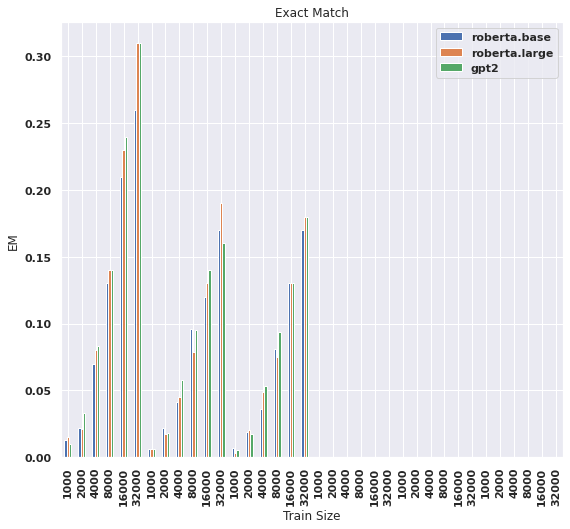

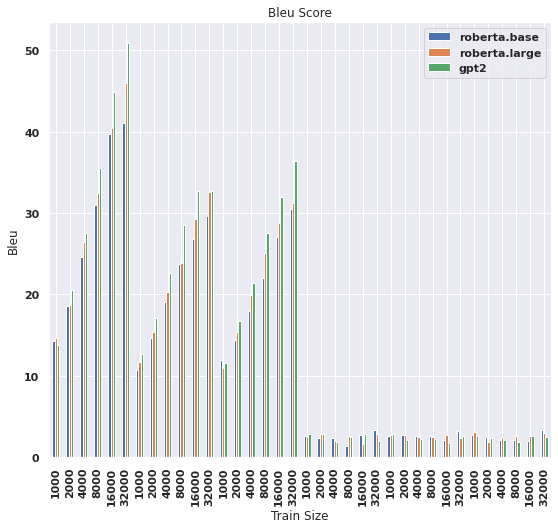

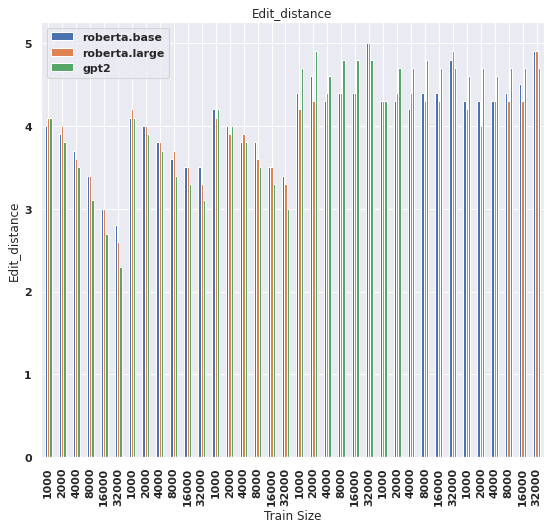

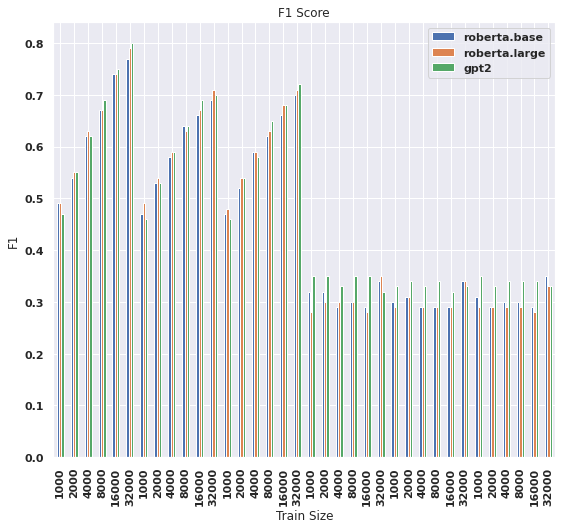

In [628]:
def get_df(model_name):
    results_file_path = checkpoints_folder + f"{model_name}_results.csv"
    df_results = pd.read_csv(results_file_path, encoding='utf-8')
    df_results['model'] = model_name
    return df_results
    

roberta_base_df = get_df('roberta.base')
roberta_large_df = get_df('roberta.large')
gpt2_df = get_df('gpt2')

#df_results = roberta_base_df.join(roberta_large_df.join(gpt2_df_results, on='train_size'), on='train_size')
# frames = [roberta_base_df["EM_score"], roberta_large_df["EM_score"], gpt2_df["EM_score"]]
# df_results = pd.concat(frames, keys=['base', 'large', 'gpt2'])
# print(df_results)
# #df_results.set_index('train_size')

# print(df_results)

# df_results.plot(x="train_size", y=["EM_score"], kind="bar", figsize=(9, 8))
# mp.show()
##################### EM #######################
plotdata = pd.DataFrame({
    "roberta.base":list(roberta_base_df["EM_score"]),
    "roberta.large":list(roberta_large_df["EM_score"]),
    "gpt2":list(gpt2_df["EM_score"]),
    }, 
    index=list(gpt2_df["train_size"])
)
plotdata.plot(kind="bar", figsize=(9, 8))
plt.title("Exact Match")
plt.xlabel("Train Size")
plt.ylabel("EM")

##################### BLEU #######################
plotdata = pd.DataFrame({
    "roberta.base":list(roberta_base_df["Bleu_score"]),
    "roberta.large":list(roberta_large_df["Bleu_score"]),
    "gpt2":list(gpt2_df["Bleu_score"]),
    }, 
    index=list(gpt2_df["train_size"])
)


plotdata.plot(kind="bar", figsize=(9, 8))
plt.title("Bleu Score")
plt.xlabel("Train Size")
plt.ylabel("Bleu")
#################### Hamming ########################
plotdata = pd.DataFrame({
    "roberta.base":list(roberta_base_df["Hamming_dist"]),
    "roberta.large":list(roberta_large_df["Hamming_dist"]),
    "gpt2":list(gpt2_df["Hamming_dist"]),
    }, 
    index=list(gpt2_df["train_size"])
)


plotdata.plot(kind="bar", figsize=(9, 8))
plt.title("Edit_distance")
plt.xlabel("Train Size")
plt.ylabel("Edit_distance")
#################### F1 ########################
plotdata = pd.DataFrame({
    "roberta.base":list(roberta_base_df["f_1"]),
    "roberta.large":list(roberta_large_df["f_1"]),
    "gpt2":list(gpt2_df["f_1"]),
    }, 
    index=list(gpt2_df["train_size"])
)


plotdata.plot(kind="bar", figsize=(9, 8))
plt.title("F1 Score")
plt.xlabel("Train Size")
plt.ylabel("F1")

# df_results.plot(x="train_size", y=["Bleu_score"], kind="bar", figsize=(9, 8))
# mp.show()

# with open(results_file_path, 'r') as f:
#     for line in f.readlines():
#         if first_line:
#             first_line = False
#             continue
#         bleu_idx = re.search('%', line).span()[1]-5
#         bleu_score = float(line[bleu_idx:bleu_idx+4])
#         print(bleu_idx)
#         print(bleu_score)
#         if 'random_split' in line:
#             print("bla")
            
                

### Create Pre-training Wikipedia data

In [34]:
from datasets import load_dataset
wiki_dataset = load_dataset('wikipedia', '20200501.en', cache_dir='/home/olab/itayitzhak/bpeplus/wikipedia_dump/')
print(wiki_dataset)

Reusing dataset wikipedia (/home/olab/itayitzhak/bpeplus/wikipedia_dump/wikipedia/20200501.en/1.0.0/2fe8db1405aef67dff9fcc51e133e1f9c5b0106f9d9e9638188176d278fd5ff1)



DatasetDict({
    train: Dataset({
        features: ['title', 'text'],
        num_rows: 6078422
    })
})


In [86]:
def get_valid_test_doc_ids():
    doc_ids = []
    with open('/home/yandex/AMNLP2021/data/wiki/all', 'r') as f_wiki:
        nums = re.compile('<doc id=\"[0-9]+\"')
        for line in f_wiki.readlines():
            if line.startswith('<doc id='):
                doc_id_end_index = nums.search(line).span()[1] - 1
                doc_id = int(line[9:doc_id_end_index])
                doc_ids.append(doc_id)
    return doc_ids

print(len(get_valid_test_doc_ids()))

3811706


In [88]:
def prepare_wiki_article(article):
    print("article['text']", article['text'])
    cutoff_idx = len(article['text'])
    
    if '\nSee also \n' in article['text']:
        cutoff_idx = re.search('\nSee also \n', article['text']).span()[0]
    if '\nReferences \n' in article['text']:
        cutoff_idx = min(cutoff_idx, re.search('\nReferences \n', article['text']).span()[0])
    if '\nCategory \n' in article['text']:
        cutoff_idx = min(cutoff_idx, re.search('\nCategory \n', article['text']).span()[0])
    if '\nExternal links \n' in article['text']:
        cutoff_idx = min(cutoff_idx, re.search('\nExternal links \n', article['text']).span()[0])

    print("*"*60)
    article['text'] = article['text'][:cutoff_idx]
    print(article['text'])
    print("="*120)
    return article['title']+'\n\n'+article['text']


f_train = open('/home/olab/itayitzhak/bpeplus/wikipedia_dump/train.hugging', 'w')
f_valid = open('/home/olab/itayitzhak/bpeplus/wikipedia_dump/valid.hugging', 'w')
f_test = open('/home/olab/itayitzhak/bpeplus/wikipedia_dump/test.hugging', 'w')

# valid_and_test_size = 30000
# valid_and_test_size_indices = np.random.choice(len(wiki_dataset['train']), valid_and_test_size) 
# test_indices = valid_and_test_size_indices[:5000]
# valid_indices = valid_and_test_size_indices[5000:]

# test_indices = [2,4]
# valid_indices = [5,6,7]

# for i in range(len(wiki_dataset['train'])):
#     article = wiki_dataset['train'][i]
#     if i in valid_indices:
#         f_valid.write(prepare_wiki_article(article))
#     elif i in test_indices:
#         f_test.write(prepare_wiki_article(article))
#     else:
#         f_train.write(prepare_wiki_article(article))
#     if i > 9:
#         break


    
#     valid_and_test_size = 30000
#     valid_and_test_size_indices = np.random.choice(len(wiki_dataset['train']), valid_and_test_size) 
#     test_indices = valid_and_test_size_indices[:5000]
#     valid_indices = valid_and_test_size_indices[5000:]
    
        
with open('/home/yandex/AMNLP2021/data/wiki/all', 'r') as f_wiki:
    currntly_writing_to = 'train'
#     test_docs = [12]
#     valid_docs = [2668]
    all_docs = get_valid_test_doc_ids()
    
    valid_size = 19000
    test_valid_docs = np.random.choice(all_docs, 24000) 
    
    valid_docs = test_valid_docs[:valid_size]
    test_docs = test_valid_docs[valid_size:]

    nums = re.compile('<doc id=\"[0-9]+\"')
    for i, line in enumerate(f_wiki.readlines()):
        if line.startswith('<doc id='):
            doc_id_end_index = nums.search(line).span()[1] - 1
            doc_id = int(line[9:doc_id_end_index])
            if doc_id in test_docs:
                currntly_writing_to = 'test'
            elif doc_id in valid_docs:
                currntly_writing_to = 'valid'
            else:
                currntly_writing_to = 'train'
            continue
        if line == '</doc>':
            continue
            
        if currntly_writing_to == 'valid':
            f_valid.write(line)
        elif currntly_writing_to == 'test':
            f_test.write(line)
        else:
            f_train.write(line)
#         print(line)
#         print("i", i)
#         if i > 190:
#             break
        
f_train.close()
f_valid.close()
f_test.close()

### Save GPT2 and AraBERT

In [394]:
#!pip install transformers
from transformers import AutoTokenizer, AutoModelWithLMHead, GPT2Model
tokenizer = AutoTokenizer.from_pretrained("gpt2")
print(tokenizer)
model = AutoModelWithLMHead.from_pretrained("gpt2-medium")
#model = GPT2Model.from_pretrained('gpt2')
print(model)
# from transformers import pipeline, set_seed
# generator = pipeline('text-generation', model='gpt2-medium')
# generator("The White man worked as a", max_length=10, num_return_sequences=5)

PreTrainedTokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_len=1024, is_fast=True, padding_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'})
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elemen

In [ ]:
gpt2_emb = torch.load('/home/olab/itayitzhak/bpeplus/gpt2/gpt2-medium-emb.pt')
embed_tokens = torch.ones(50261, 1024)
loaded_emb_matrix = torch.cat([embed_tokens[0:4,:],gpt2_emb], dim=0)#[:-4, :]
print(loaded_emb_matrix.shape)
print(print(loaded_emb_matrix[0:5,0:10]))

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
  
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-large-arabertv02")

model = AutoModelForMaskedLM.from_pretrained("aubmindlab/bert-large-arabertv02")

print(tokenizer)
print(model)

# From tokenizer debugging:
# special_tokens: ['[UNK]', '[SEP]', '[PAD]','[CLS]','[MASK]']
# special_tokens_ids: [1,3,0,2,4]


In [481]:
t = torch.load('/home/olab/itayitzhak/bpeplus/AraBERT/bert-large-arabertv02_vocab.pt')
t = sorted(t.items(), key=lambda x:x[1])
t = dict(t)

with open('/home/olab/itayitzhak/bpeplus/AraBERT/dict.txt', 'w') as f:
    for word, num in t.items():
        if int(num) < 5:
            continue
        f.write(word + ' ' + str(num) + '\n')

## Mistakes Histograms, not History

In [382]:
def get_error_place(token, token_from_chars):
    error_place = 0
    for i in range(min(len(token), len(token_from_chars))):
        if token[i] is not token_from_chars[i]:
            break
        else:
            error_place += 1
    if len(token) == len(token_from_chars) == error_place:
        return -1 # correct answer is marked with -1
    else:
        return error_place

def get_prefix_histogram(fname):
    histogram = []
    with open(fname, 'r') as f:
        for line in f.readlines():
            if line[0] == 'H':
                line = line.replace('\n','').split('\t')[2].split(' ')
                token = line[0].strip()
                token_from_chars = ''.join(line[1:])
                histogram.append(get_error_place(token, token_from_chars))
    return histogram

    for token, token_from_chars in inputs:
        histogram.append(get_error_place(token, token_from_chars))
    return histogram

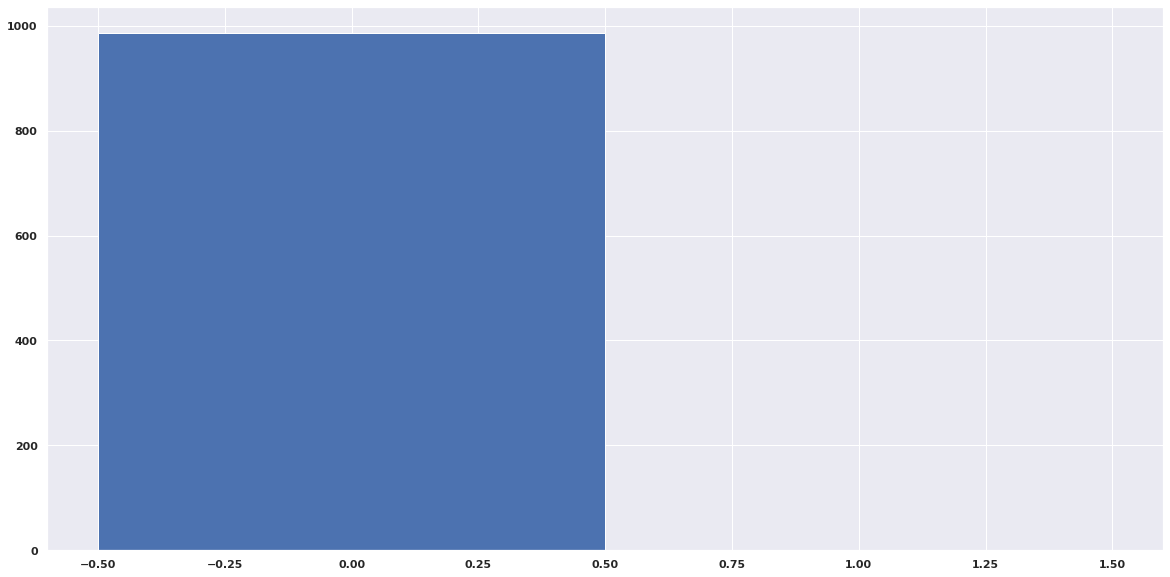

In [384]:
import matplotlib.pyplot as plt

data = get_prefix_histogram(checkpoints_folder+model_to_eval+"/generate-test.txt")
#plt.hist(data, bins = max(histogram)+1)
import numpy as np

data = np.array(data)
d = np.diff(np.unique(data)).min()
left_of_first_bin = data.min() - float(d)/2
right_of_last_bin = data.max() + float(d)/2
plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))

plt.show()

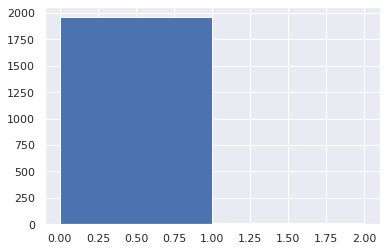

In [103]:
histogram = get_prefix_histogram(checkpoints_folder+"not_trained_"+model_to_eval+"/generate-test.txt")
plt.hist(histogram, bins = max(histogram))
plt.show()

## RoBERTAs' Pre-Training

In [329]:
def get_losses(fname):
    train_losses = []
    valid_losses = []
    
    with open(fname, 'r') as f:
        for line in f.readlines():
            # train loss
            if 'INFO | train_inner | epoch ' in line:
                train_loss_idx = re.search('loss=', line).span()[1]
                end_train_loss_idx = re.search(', ppl=', line).span()[0]
                #print(line)
                #print(line[train_loss_idx:end_train_loss_idx])
                train_loss = float((line[train_loss_idx:end_train_loss_idx]))
                train_losses.append(train_loss)
                        
            if ' valid on \'valid\' subset | loss' in line:
                valid_loss_idx = re.search('loss ', line).span()[1]
                end_valid_loss_idx = re.search('ppl', line).span()[0]-3
                #print(line)
                #print(f"valid_loss_idx:{valid_loss_idx} end_valid_loss_idx: {end_valid_loss_idx}")
                #print(line[valid_loss_idx:end_valid_loss_idx])
                valid_loss = float((line[valid_loss_idx:end_valid_loss_idx]))
                valid_losses.append(valid_loss)
    return train_losses, valid_losses

In [335]:
model_version = "baseline"
baseline_train_losses, baseline_valid_losses =  get_losses(checkpoints_folder+model_version+'_roBERTa_pre_train/'+model_version+'_roberta_pre-training.out')

model_version = "loaded"
loaded_train_losses, loaded_valid_losses =  get_losses(checkpoints_folder+model_version+'_roBERTa_pre_train/'+model_version+'_roberta_pre-training.out')

model_version = "char_emb"
char_emb_train_losses, char_emb_valid_losses =  get_losses(checkpoints_folder+model_version+'_roBERTa_pre_train/'+model_version+'_roberta_pre-training.out')

print("Number of steps for baseline:",len(baseline_train_losses))
print("Number of steps for loaded:",len(loaded_train_losses))
print("Number of steps for char_emb:",len(char_emb_train_losses))

Number of steps for baseline: 16531
Number of steps for loaded: 15790
Number of steps for char_emb: 12379


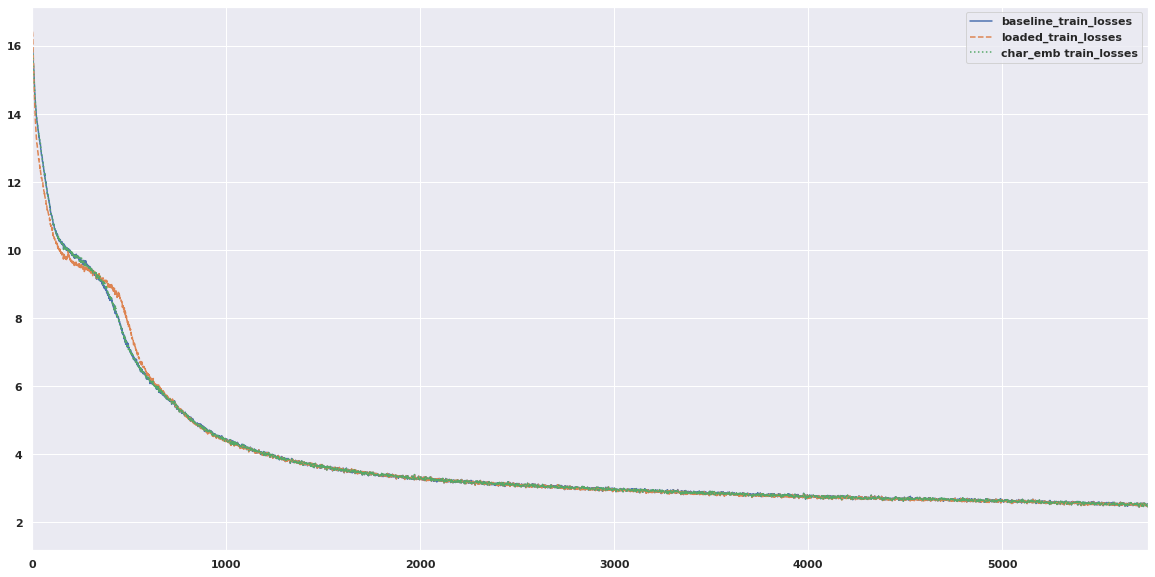

In [338]:
import matplotlib.pyplot as plt
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
plt.rcParams["figure.figsize"] = (20,10)
  
# plot lines
plt.plot(baseline_train_losses, label = "baseline_train_losses", linestyle="-")
plt.plot(loaded_train_losses, label = "loaded_train_losses", linestyle="--")
plt.plot(char_emb_train_losses, label = "char_emb train_losses", linestyle=":")
# plt.plot(unicode_belu, label = "unicode_belu val", linewidth=4, linestyle=":")
# plt.plot(pre_trained_init_belu, label = "pre_trained_init_belu val", linestyle="-.")
# plt.plot(fixed_unicode_belu, label = "fixed_unicode_belu val", linewidth=6, linestyle=":")
# plt.plot(vocab_belu, label = "vocab_belu val", linewidth=6, linestyle="dashed")
# plt.plot(vocab_pad_belu, label = "vocab_pad_belu val", linewidth=6, linestyle="dashdot")

plt.xlim(0, 5750)
#plt.ylim(2,4)

plt.legend()
plt.show()

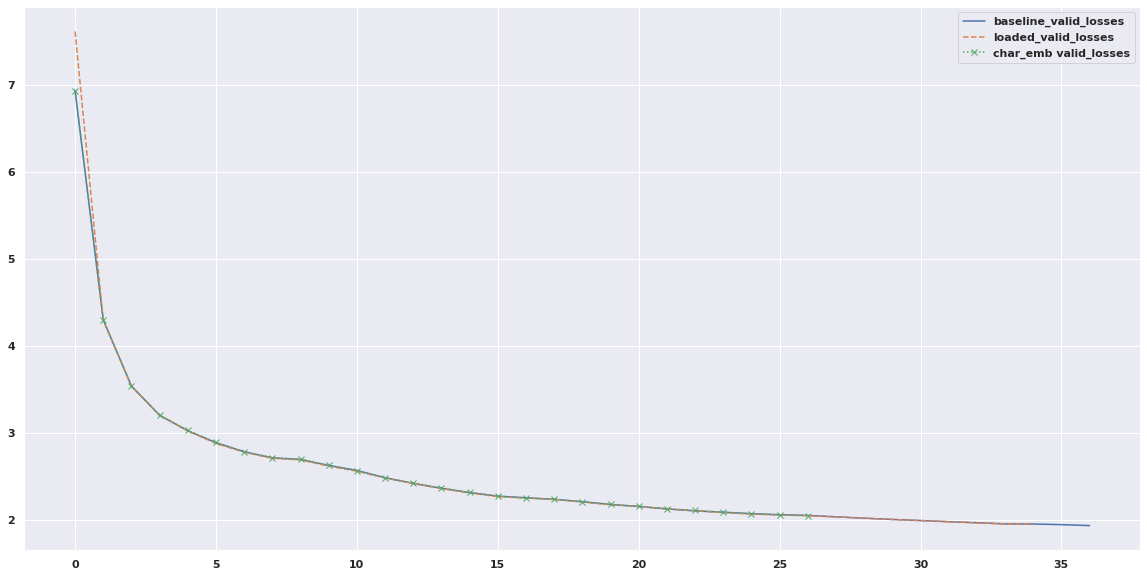

In [386]:
#### import matplotlib.pyplot as plt
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
plt.rcParams["figure.figsize"] = (20,10)
  
# plot lines
plt.plot(baseline_valid_losses, label = "baseline_valid_losses", linestyle="-")
plt.plot(loaded_valid_losses, label = "loaded_valid_losses", linestyle="--")
plt.plot(char_emb_valid_losses, label = "char_emb valid_losses", linestyle=":", marker='x')
# plt.plot(unicode_belu, label = "unicode_belu val", linewidth=4, linestyle=":")
# plt.plot(pre_trained_init_belu, label = "pre_trained_init_belu val", linestyle="-.")
# plt.plot(fixed_unicode_belu, label = "fixed_unicode_belu val", linewidth=6, linestyle=":")
# plt.plot(vocab_belu, label = "vocab_belu val", linewidth=6, linestyle="dashed")
# plt.plot(vocab_pad_belu, label = "vocab_pad_belu val", linewidth=6, linestyle="dashdot")

#plt.xlim(0,5)
#plt.ylim(10.96,10.99)

plt.legend()
plt.show()